# Data Loading and Overview

## Import

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

## Load data

In [2]:
sample_submission = pd.read_csv('sample_submission.csv')
display(sample_submission.head())

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(train.shape)
print(test.shape)

(5732, 785)
(28000, 784)


## Data overview

In [4]:
display(train.head())
display(train.info())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5732 entries, 0 to 5731
Columns: 785 entries, label to pixel783
dtypes: float64(409), int64(376)
memory usage: 34.3 MB


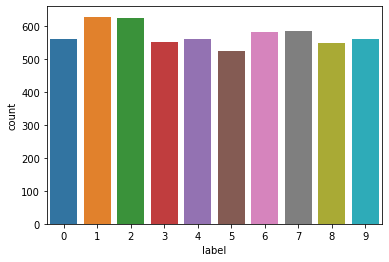

In [5]:
# labels distribution
sns.countplot(train["label"])
plt.show()

### Missing values

In [6]:
rows_with_nan = [index for index, row in train.iterrows() if row.isnull().any()]
len(rows_with_nan)

1

In [7]:
train.dropna(inplace=True)
train.shape

(5731, 785)

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
train_labels = train["label"]
train_features = train.drop(labels=["label"], axis=1) 

# free some space
del train

print(train_features.shape)
print(train_labels.shape)

(5731, 784)
(5731,)


### Normalization

In [10]:
train_features = train_features / 255.0
test = test / 255.0

### Reshape

In [11]:
train_features = train_features.values.reshape(train_features.shape[0], 28, 28, 1)
test = test.values.reshape(test.shape[0], 28, 28, 1)
print(train_features.shape)
print(test.shape)

(5731, 28, 28, 1)
(28000, 28, 28, 1)


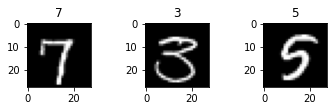

In [12]:
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_features[i], cmap=plt.get_cmap('gray'))
    plt.title(train_labels[i])

### Labels encoding

In [13]:
from keras.utils.np_utils import to_categorical

train_labels = to_categorical(train_labels)
print(train_labels.shape)

2022-08-29 12:17:20.333378: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 12:17:20.333409: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(5731, 10)


### Train-test split

In [14]:
random_seed = 2
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=random_seed)

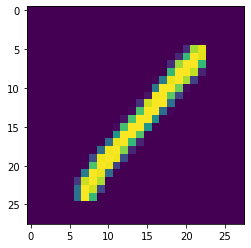

In [15]:
plt.imshow(X_train[0][:,:,0])

# Modeling

## Keras

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [89]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(10, activation = "softmax"))

In [90]:
optimizer = RMSprop(lr=0.01, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        832       
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_27 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_33 (Conv2D)          (None, 14, 14, 64)        36928     
                                                     

In [91]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
train_history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=10, callbacks=[checkpoint], verbose=2)


Epoch 1/20
459/459 - 35s - loss: 3.1080 - accuracy: 0.0945 - val_loss: 2.3011 - val_accuracy: 0.0994 - 35s/epoch - 76ms/step
Epoch 2/20
459/459 - 34s - loss: 2.3042 - accuracy: 0.1071 - val_loss: 2.3035 - val_accuracy: 0.0994 - 34s/epoch - 74ms/step
Epoch 3/20
459/459 - 34s - loss: 2.3048 - accuracy: 0.1023 - val_loss: 2.3029 - val_accuracy: 0.1020 - 34s/epoch - 73ms/step
Epoch 4/20
459/459 - 34s - loss: 2.3031 - accuracy: 0.1119 - val_loss: 2.3054 - val_accuracy: 0.1081 - 34s/epoch - 74ms/step
Epoch 5/20
459/459 - 34s - loss: 2.3045 - accuracy: 0.0990 - val_loss: 2.3025 - val_accuracy: 0.1160 - 34s/epoch - 74ms/step
Epoch 6/20
459/459 - 34s - loss: 2.3047 - accuracy: 0.1008 - val_loss: 2.3017 - val_accuracy: 0.1081 - 34s/epoch - 75ms/step
Epoch 7/20
459/459 - 33s - loss: 2.3047 - accuracy: 0.0988 - val_loss: 2.3021 - val_accuracy: 0.1160 - 33s/epoch - 73ms/step
Epoch 8/20
459/459 - 34s - loss: 2.3046 - accuracy: 0.1032 - val_loss: 2.3025 - val_accuracy: 0.1160 - 34s/epoch - 73ms/step


### Evaluation

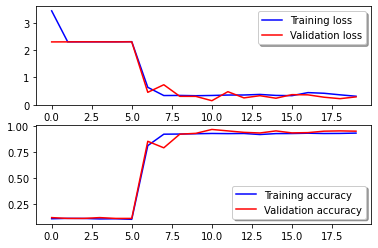

In [88]:
fig, ax = plt.subplots(2,1)
ax[0].plot(train_history.history['loss'], color='b', label="Training loss")
ax[0].plot(train_history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(train_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(train_history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()